### Processing train data



In [1]:
import pandas as pd  
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests

import emoji
import unicodedata as uni

import pymongo
from pymongo import MongoClient
from bson import ObjectId
import urllib.parse

%matplotlib inline
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


#### 1.1 Loading data

In [2]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("./traindata/training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding = "ISO-8859-1")
df.drop(['id', 'date', 'query_string', 'user'], axis=1, inplace=True)

In [3]:
df['sentiment'] = df['sentiment'].map({0:0, 4:1})

{'whiskers': [<matplotlib.lines.Line2D at 0x7f366947fc18>,
 'caps': [<matplotlib.lines.Line2D at 0x7f366947f6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f366947feb8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f366b1e9e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f366b1e9828>],
 'means': []}

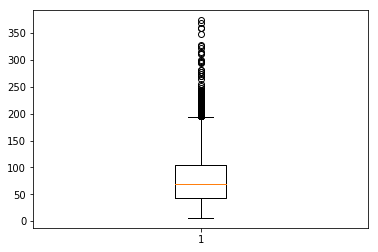

In [4]:
df['pre_clean_len'] = [len(text) for text in df['text']]
plt.boxplot(df['pre_clean_len'])

#### 1.2 cleaning data

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from textblob import Word, TextBlob
import enchant

In [6]:
test = 'RT @PumpMyCoins: When you reach the pinnacle of #Bitcoin enlightenment 😇👩🏻‍🚀👨🏻‍🚀\n\nLeverage Available ✅\n\n▶️ https://t.co/SmHZ8nFsKr ◀️\n\nRegi…'
test = 'i hasn\'t aren\'t it\'s i\'ve i\'d don\'t isn\'t haven\'t i\'m didn\'t' + test

In [7]:
def initMongo(client, collection):
    db = client['longhash']
    try:
        db.create_collection(collection)
    except:
        pass
    return db[collection]

# 获取单词的词性
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def my_word_lemmatize(sentence):   
    tokens = word_tokenize(sentence)  # 分词
    tagged_sent = pos_tag(tokens)     # 获取单词词性

    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原

    return lemmas_sent


In [8]:
def clear_tweet_text(text, emoji_data):
    filters = ['rt','io','...','..','quot','gt']
    
    pat1 = r'@[A-Za-z0-9_.-]+'
    pat2 = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    combined_pat = r'|'.join((pat1, pat2))    
    text_cleaned = re.sub(combined_pat, ' ', text)
    
    text_cleaned = ' '.join([' '+emoji_data[w]+' ' if w in emoji_data.keys() else w for w in nltk.word_tokenize(text_cleaned)])
    text_cleaned = ''.join([' '+emoji_data[c]+' ' if c in emoji_data.keys() else c for c in text_cleaned ])
   
    letters_only = re.sub("[^a-zA-Z!?\.']", " ", text_cleaned)
    lower_case = letters_only.lower()
    lower_case = lower_case.replace('n\'t',' not')
    
    words = my_word_lemmatize(lower_case) 
    
    words = [i for i in words if (len(i)>1) or (i in ['i'])]
    cleaned_words = [word for word in words if (d.check(word))]
    
#     words = nltk.word_tokenize(lower_case) 
    
#     wordnet_lem = WordNetLemmatizer()
#     words = [wordnet_lem.lemmatize(i) for i in words]
#     #cleaned_words = [i for i in words if (len(i)>1) or (i in ['!','?','i'])]

    cleaned_words = [i for i in cleaned_words if i not in filters]
    
    return ' '.join(cleaned_words)

In [9]:
d = enchant.Dict("en_US")
emoji_client = initMongo(MongoClient('mongodb://root:' + urllib.parse.quote('longhash123!@#QAZ') + '@127.0.0.1'), 'emoji_name')    
emoji_data = [emoji_client.find_one()][0]   
del emoji_data['_id']

clear_tweet_text(test, emoji_data)

'i have not be not it i i do not be not have not i do when you reach the pinnacle of enlightenment smile face with halo woman man leverage available'

In [10]:
# clean twitter data 
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
    
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text() # Html Decoding
    stripped = re.sub(combined_pat, '', souped) # removing symbols and url
    try: # UTF-8 BOM 
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean) # keep only letters
    lower_case = letters_only.lower() # lower
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    
    analysis = TextBlob(lower_case)
    words = analysis.words
    words = [word.singularize() for word in words]
    words = [word.lemmatize() for word in words]
    return (" ".join(words)).strip()

In [11]:
clean_texts = []
for i in range(df['text'].count()):
    if((i+1)%10000==0):
        print ('Tweets {} of 1600000 have been processed'.format(i+1))
    clean_texts.append(clear_tweet_text(df['text'][i], emoji_data))

Tweets 10000 of 1600000 have been processed
Tweets 20000 of 1600000 have been processed
Tweets 30000 of 1600000 have been processed
Tweets 40000 of 1600000 have been processed
Tweets 50000 of 1600000 have been processed
Tweets 60000 of 1600000 have been processed
Tweets 70000 of 1600000 have been processed
Tweets 80000 of 1600000 have been processed
Tweets 90000 of 1600000 have been processed
Tweets 100000 of 1600000 have been processed
Tweets 110000 of 1600000 have been processed
Tweets 120000 of 1600000 have been processed
Tweets 130000 of 1600000 have been processed
Tweets 140000 of 1600000 have been processed
Tweets 150000 of 1600000 have been processed
Tweets 160000 of 1600000 have been processed
Tweets 170000 of 1600000 have been processed
Tweets 180000 of 1600000 have been processed
Tweets 190000 of 1600000 have been processed
Tweets 200000 of 1600000 have been processed
Tweets 210000 of 1600000 have been processed
Tweets 220000 of 1600000 have been processed
Tweets 230000 of 16

In [12]:
#df = pd.read_csv('./traindata/my_clean_data_nopunctuation.csv')
df.to_csv('./traindata/my_clean_data_nopunctuation.csv')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f364b0827f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f364b082eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f364b0826a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f364b08d588>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f364b08d8d0>],
 'means': []}

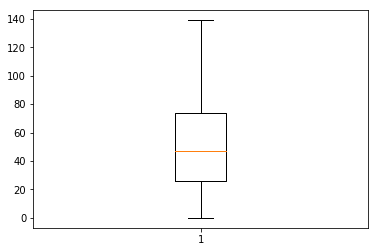

In [13]:
df['clean_text'] = clean_texts
df['after_clean_len'] = [len(text) for text in df['clean_text']]
plt.boxplot(df['after_clean_len'])

In [14]:
outlier = df[df['after_clean_len']>150]
len(outlier)

0

In [15]:
outlier

,sentiment,text,pre_clean_len,clean_text,after_clean_len


In [16]:
#df.loc[df.index[1447652],'text']

In [17]:
#clear_tweet_text(df.loc[df.index[1447652],'text'],emoji_data)

In [18]:
#tweet_cleaner(df.loc[df.index[1447652],'text'])

#### 1.3 Loading Pre-trained Word2vec model


In [19]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('./traindata/GoogleNews-vectors-negative300.bin', binary=True )
embeddings_index = {}
for w in w2v_model.vocab.keys():
    embeddings_index[w] = w2v_model[w]

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

df['clean_text'] = [str(text) for text in df['clean_text'].tolist()]
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(df['clean_text']) # 只fit一次，多次fit会得到不同的序列号!!
sequences = tokenizer.texts_to_sequences(df['clean_text'])
x_seq = pad_sequences(sequences, maxlen=140)

Using TensorFlow backend.


In [21]:
import pickle

#saving
with open('./tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)


In [22]:
num_words = 100000 # only keep top 60000 words
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
def train_test_split(df):
    train = np.concatenate((df[:750000], df[800000:1550000]))
    test = np.concatenate((df[750000:800000], df[1550000:]))
    return train, test
# def train_test_split(df):
#     train = np.concatenate((df[:75000], df[800000:875000]))
#     test = np.concatenate((df[750000:760000], df[875000:885000]))
#     return train, test

x_train_seq, x_test_seq = train_test_split(x_seq)
y_train, y_test = train_test_split(df['sentiment'])

In [24]:
# np.save('./traindata/x.np', x_seq)
# x_seq = np.fromfile('./traindata/x.np')

#### 1.4 Train Classification Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [26]:
model = Sequential()
e = Embedding(100000, 300, weights=[embedding_matrix], input_length=140, trainable=True)
model.add(e)

model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# filepath="/root/notebook/Sentiment/trainresult/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#model.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=3, batch_size=10000, callbacks = [checkpoint])

#filepath="./weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = './best_cnn_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=30, batch_size=10000, callbacks=[checkpoint,early_stopping])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1500000 samples, validate on 100000 samples
Epoch 1/30
1500000/1500000 [==============================] - 966s 644us/step - loss: 0.4740 - acc: 0.7719 - val_loss: 0.4364 - val_acc: 0.7970

Epoch 00001: val_acc improved from -inf to 0.79699, saving model to ./best_cnn_weights.hdf5
Epoch 2/30
1500000/1500000 [==============================] - 916s 611us/step - loss: 0.4151 - acc: 0.8099 - val_loss: 0.4231 - val_acc: 0.8054

Epoch 00002: val_acc improved from 0.79699 to 0.80537, saving model to ./best_cnn_weights.hdf5
Epoch 3/30
1500000/1500000 [==============================] - 860s 574us/step - loss: 0.3943 - acc: 0.8217 - val_loss: 0.4257 - val_acc: 0.8040

Epoch 00003: val_acc did not improve from 0.80537
Epoch 4/30
1500000/1500000 [==============================] - 1080s 720us/ste

In [33]:
tt = ['i do not hate bitcoin']

sequences = tokenizer.texts_to_sequences(tt)
print(sequences)
x_seq = pad_sequences(sequences, maxlen=140)
print(x_seq)

print('score:', model.predict(x_seq))

[[1, 13, 9, 129]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1  13   9 129]]
score: [[0.53182757]]


In [34]:
from keras.models import load_model

model2 = load_model('./best_cnn_weights.hdf5')
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)
    
sequences = tokenizer2.texts_to_sequences(tt)
print(sequences)
x_seq = pad_sequences(sequences, maxlen=140)
print(x_seq)

print('score:', model2.predict(x_seq))

[[1, 13, 9, 129]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1  13   9 129]]
score: [[0.53182757]]


#### 1.5 Loading history data

In [29]:
# get emoji name

# url = 'https://emojipedia.org/people/'
# r = requests.get(url)
# soup = BeautifulSoup(r.text, 'lxml')
# table = soup.find('ul',{'class':'emoji-list'})
# emoji_data = {}
# for li in table.find_all('li'):
#     emo = li.find('span',{'class':'emoji'}).get_text()
#     name = li.get_text()[len(emo):]
    
#     emoji_data[emo] = name

In [30]:
def get_hist_tweet():
    client = initMongo(MongoClient('mongodb://root:' + urllib.parse.quote('longhash123!@#QAZ') + '@127.0.0.1'), SCORE_NOW)
    twitter2 = initMongo(MongoClient('mongodb://root:' + urllib.parse.quote('longhash123!@#QAZ') + '@127.0.0.1'), 'twitter_2')

    hist_twitter = client.find()

    cnt = 0
    for item in hist_twitter:
        try:
            tmp = [clear_tweet_text(words, emoji_data) for words in item['orign_tweet']]
        except:
            exc.append(item['_id'])
            continue
        
        twitter2.insert_one({'timestamp':item['timestamp'],'created_date':item['created_date'],'clean_tweet':tmp})
        cnt += 1
        if cnt %1000==0:
            print('{} tweets cleaned'.format(cnt))
    

In [31]:
#get_hist_tweet()

In [40]:
hist_tweet = initMongo(MongoClient('mongodb://root:' + urllib.parse.quote('longhash123!@#QAZ') + '@127.0.0.1'), 'twitter_2')
twitters = hist_tweet.find()

score = []
cnt = 0
for item in twitters:
    
    tweets = item['clean_tweet']

    test_sequences = tokenizer.texts_to_sequences(tweets)
    test_sequences_padding = pad_sequences(test_sequences, maxlen=140)
    scores = model.predict(test_sequences_padding)

    score.append(round(np.mean(scores), 4))
    cnt += 1
    if cnt%10000==0:
        print('{} tweets predicted'.format(cnt))

10000 tweets predicted
20000 tweets predicted


/home/zhangli/tweet_sentiment/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zhangli/tweet_sentiment/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


30000 tweets predicted
40000 tweets predicted
50000 tweets predicted
60000 tweets predicted
70000 tweets predicted
80000 tweets predicted


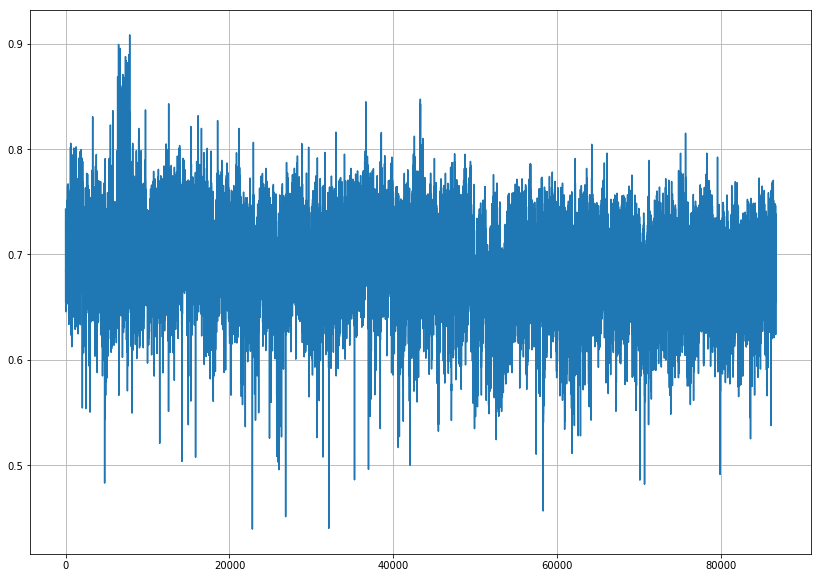

In [41]:
df = pd.DataFrame(score, columns=['score'])

plt.figure(figsize=(14,10))
plt.grid()
plt.plot(df.index,df['score'])

In [42]:
df['score_2'] = [(ele-0.5)*2 for ele in df['score'].tolist()]

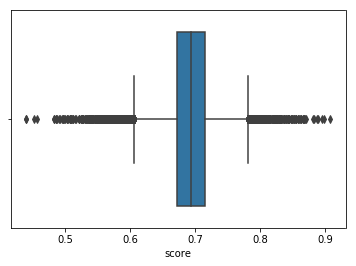

In [43]:
import seaborn as sns
sns.boxplot(df['score'])

In [68]:
tt = ['i don\'t like btc','i like btc', 'i love btc','i went to exchange','i didn\'t hate cryptocoins']
t = [clear_tweet_text(ele, emoji_data) for ele in tt]
print(t)

sequences = tokenizer2.texts_to_sequences(t)
x_seq = pad_sequences(sequences, maxlen=140)

print('score:', model2.predict(x_seq))


['i do not like', 'i like', 'i love', 'i go to exchange', 'i do not hate']
score: [[0.11579546]
 [0.70432734]
 [0.94294316]
 [0.8555896 ]
 [0.53182733]]


In [57]:
# clean twitter data 
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text() # Html Decoding
    stripped = re.sub(combined_pat, '', souped) # removing symbols and url
    try: # UTF-8 BOM 
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean) # keep only letters
    lower_case = letters_only.lower() # lower
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    
    analysis = TextBlob(lower_case)
    words = analysis.words
    words = [word.singularize() for word in words]
    words = [word.lemmatize() for word in words]
    return (" ".join(words)).strip()

In [67]:
dd = [tweet_cleaner(ele) for ele in tt]
dd

['i don t like btc',
 'i like btc',
 'i love btc',
 'i went to exchange',
 'i didn t hate cryptocoin']